In [1]:
import os
import yaml
import sgeop
import geopandas as gpd
from src import utils
import momepy
import networkx as nx
import matplotlib.pyplot as plt

### READ GENERAL CONFIGS ###
config = yaml.load(open("./config/config.yml"), Loader=yaml.FullLoader)
proj_crs = config["proj_crs"]

# ### CREATE SUBFOLDERS ###
# sub_folders = [
#     "./data/network-communication/geofa/",
# ]

# for sub_folder in sub_folders:
#     os.makedirs(sub_folder, exist_ok=True)

# print("Subfolders created...")

# ### CLEAN DATA FOLDER ###

# # remove previous output
# utils.remove_output_data(
#     sub_folders,
#     remove_previous_output=True,
#     verbose=True,
# )

# ### READ (TECHNICAL) EDGE DATA ###

# general configs
config = yaml.load(open("./config/config.yml"), Loader=yaml.FullLoader)
proj_crs = config["proj_crs"]

edges_all = gpd.read_file(
    "./data/network-technical/bikenodeplanner/cykelknudepunktsstraekninger.gpkg"
)
edges_all = edges_all.to_crs(proj_crs)

# # CUT TO FYN

# # municipalities
# municipalities = yaml.load(
#     open("./config/config-municipalities.yml"), Loader=yaml.FullLoader
# )
# codes = municipalities["kommunekode"]
# ### read in municipality boundaries & create study area polygon
# gdf = gpd.read_file("./data/municipality-boundaries/municipality-boundaries.gpkg")
# gdf = gdf.to_crs(proj_crs)  # make sure we have the right projected CRS
# gdf = gdf[
#     gdf["kommunekode"].isin(codes)
# ]  # filter to municipality codes indicated in config file

# study_poly = gdf.union_all()
# gdf_studyarea = gpd.GeoDataFrame({"geometry": [study_poly]}, crs=proj_crs)

# # # edges = edges_all.sjoin(gdf_studyarea, predicate="intersects").copy()
# # # edges.drop(columns=["index_right"], inplace=True)'
# assert gdf_studyarea.crs == edges_all.crs
# edges = edges_all.loc[edges_all.sindex.query(study_poly, predicate="intersects")].copy()
# edges = edges.reset_index(drop=True)
edges = edges_all.copy()

### preprocess edges for sgeop input ###
edges = edges[["geometry"]]
edges = edges.to_crs(proj_crs)
edges = gpd.GeoDataFrame(
    {
        "geometry": edges.geometry.explode()
    },
    crs = proj_crs
)
# removing duplicated and overlapping geoms
edges = edges[~edges.geometry.duplicated()].reset_index(drop=True)
edges_union = edges.union_all()
edge_geoms = [g for g in edges_union.geoms]
edges = gpd.GeoDataFrame(
    {
        "geometry": edge_geoms,
    },
    crs = proj_crs
)

print("Edges read in and preprocessed.")


/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


Edges read in and preprocessed.


<Axes: >

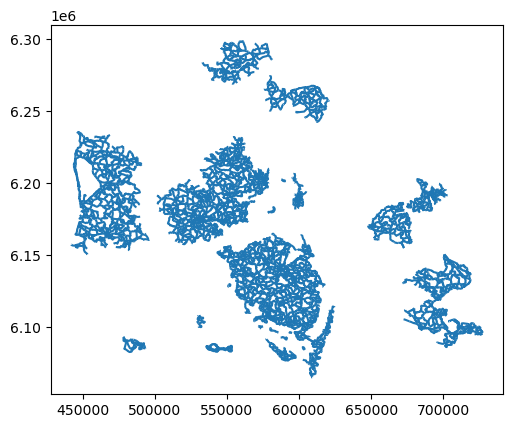

In [2]:
edges.plot()

In [ ]:
# fas = momepy.FaceArtifacts(edges).polygons.set_crs(edges.crs)
# threshold = 11
# fas["check"] = fas.face_artifact_index > threshold
# fas.explore(column = "check")

In [3]:
# simplify
print("Simplifying network...")
edges_simp = sgeop.simplify_network(
    roads=edges,
    artifact_threshold=11, # set manually!
    max_segment_length=10 # set manually!
)

Simplifying network...


/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as ETRS89 / UTM zone 32N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/sgeop/simplify.py:732: UserWarning: An error occured at location POINT (492492.7264896632 6089071.840806646). The artifact has not been simplified. The original message:
can only convert an array of size 1 to a Python scalar
  roads = simplify_singletons(
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/sgeop/simplify.py:732: UserWarning: An error occured at location POINT (526295.5115390733 6197266.793869437). The artifact has not been simplified. The original message:
can only convert an array of size 1 to a Python scalar
  roads = simplify_singletons(
/Users/anvy/anaconda3/envs/knupu/lib/python3.12/site-packages/sgeop/geo

In [ ]:
# edges_old = gpd.read_file("./data/network-communication/bikenodeplanner/edges.gpkg")

In [4]:
# convert to networkx object with momepy
G = momepy.gdf_to_nx(
    gdf_network=edges_simp,
    multigraph=False,
    #    integer_labels=True, # only in momepy 0.8+
    directed=False,
)
print(f"The number of connected components is: {nx.number_connected_components(G)}")
comps = [c for c in nx.connected_components(G)]
comps = sorted(comps, key=len, reverse=True)  # sort by length (LCC first)

# for comp in comps:

#     # for each component, make subgraph
#     G_sub = nx.subgraph(G, nbunch=comp)

#     # using momepy to get nodes and edges gdf with corresponding labels and geometry objects
#     edgescomp = momepy.nx_to_gdf(
#         net = G_sub,
#         points = False,
#         lines = True
#     )
#     edgescomp.plot()

The number of connected components is: 30


In [5]:
# save to file
print("Saving to file...")
edges_simp.to_file(
    "./data/network-communication/bikenodeplanner/edges.gpkg"
)


Saving to file...
